# Data Cleaning
Author Brian Tam, 10/16/2020

This notebook is used to clean the [MBTI kaggle dataset](https://www.kaggle.com/datasnaek/mbti-type) as an intermediate setup to prep it for moding.
The following was done:
1. Preprocess so that each row is consists of all the posts from an individual person
2. Filter out links
3. Use spaCy to tolkenize, lemmetize, and remove stop words 
4. Perform EDA to understand class distribution and nature of texts
5. Imported and exported as SQL tables using d6tstack

In [22]:
# Get pandas and postgres to work together
import psycopg2 as pg
import pandas as pd
import numpy as np
import pickle 

# Import spacy to do NLP
import spacy

# Split the data into training and test sets
from sklearn.model_selection import train_test_split

# Import sklearn to do CountVectorizing
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

import matplotlib.pyplot as plt

# Topic Modeling
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

# Text Preprocessing
import re
import string

Lets connect to the kaggle dataset in our psql database

In [3]:
# Postgres info to connect
connection_args = {
    'host': 'localhost',  # We are connecting to our _local_ version of psql
    'dbname': 'myers_briggs',    # DB that we are connecting to
}

connection = pg.connect(**connection_args)  # What is that "**" there??

query = "SELECT * FROM twitter_origin;"

df = pd.read_sql(query, connection)
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


## Multiclass to binary classification
Since it'll be easier to do binary classification, I create boolians for each Letter pair

In [4]:
map1 = {"I": 1, "E": 0}
map2 = {"S": 0, "N": 1}
map3 = {"T": 0, "F": 1}
map4 = {"J": 0, "P": 1}
df['E/I'] = df['type'].astype(str).str[0]
df['E/I'] = df['E/I'].map(map1)
df['N/S'] = df['type'].astype(str).str[1]
df['N/S'] = df['N/S'].map(map2)
df['F/T'] = df['type'].astype(str).str[2]
df['F/T'] = df['F/T'].map(map3)
df['P/J'] = df['type'].astype(str).str[3]
df['P/J'] = df['P/J'].map(map4)

In [7]:
df

,type,posts,E/I,N/S,F/T,P/J
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,1,0
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,0,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,0,1
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,0,0
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,0,0
...,...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,1,0,1,1
8671,ENFP,'So...if this thread already exists someplace ...,0,1,1,1
8672,INTP,'So many questions when i do these things. I ...,1,1,0,1
8673,INFP,'I am very conflicted right now when it comes ...,1,1,1,1


## Split posts
One post per row

In [8]:
df['post'] = df.apply(lambda row: row.posts.split('|||'), axis = 1) 

In [9]:
def quoteRemover(x):
    """
    Removes the annoying single quote sign at the beginning and end of all the post chains.

    """
    if re.match("'",x[0]):
        x[0] = x[0][1:]
    if re.match("'",x[-1][::-1]):
        x[-1] = x[-1][:-1]

df['post'].apply(quoteRemover)

0       None
1       None
2       None
3       None
4       None
        ... 
8670    None
8671    None
8672    None
8673    None
8674    None
Name: post, Length: 8675, dtype: object

In [10]:
df = df.drop(['posts'],axis=1)

### Join posts together instead of Exploding

In [11]:
df.post.head()

0    [http://www.youtube.com/watch?v=qsXHcwe3krw, h...
1    [I'm finding the lack of me in these posts ver...
2    [Good one  _____   https://www.youtube.com/wat...
3    [Dear INTP,   I enjoyed our conversation the o...
4    [You're fired., That's another silly misconcep...
Name: post, dtype: object

### Remove links from your posts

In [12]:
df['post_no_links'] = df.post.apply(lambda x: [post for post in x if 'http' not in post])

In [13]:
df['post_no_links']=df.post_no_links.apply(lambda x: ' '.join(x))

In [14]:
df.head()

,type,E/I,N/S,F/T,P/J,post,post_no_links
0,INFJ,0,1,1,0,"[http://www.youtube.com/watch?v=qsXHcwe3krw, h...",What has been the most life-changing experienc...
1,ENTP,1,1,0,1,[I'm finding the lack of me in these posts ver...,I'm finding the lack of me in these posts very...
2,INTP,0,1,0,1,[Good one _____ https://www.youtube.com/wat...,"Of course, to which I say I know; that's my bl..."
3,INTJ,0,1,0,0,"[Dear INTP, I enjoyed our conversation the o...","Dear INTP, I enjoyed our conversation the ot..."
4,ENTJ,1,1,0,0,"[You're fired., That's another silly misconcep...",You're fired. That's another silly misconcepti...


# SpaCy and Regex preprocessing

In [23]:
import spacy
import re
import string
# Create our list of punctuation marks
punctuations = string.punctuation

# Load English tokenizer, tagger, parser, NER and word vectors
parser = spacy.load('en_core_web_sm')

# Create our list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)
    
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    # return preprocessed list of tokens
    return ' '.join(mytokens)

In [19]:
pd.to_pickle(parser, 'pickled_transformations/parser.pkl')
pd.to_pickle(stop_words, 'pickled_transformations/stop_words.pkl')

In [64]:
df['spacy_post'] = df.post_no_links.apply(spacy_tokenizer) #.map(alphanumeric).map(punc_lower)

In [65]:
alphanumeric = lambda x: re.sub('\w*\d\w*', '', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower())

In [66]:
df['clean_post'] = df.spacy_post.map(alphanumeric).map(punc_lower)
df.head()

,type,E/I,N/S,F/T,P/J,post,post_no_links,spacy_post,clean_post
0,INFJ,0,1,1,0,"[http://www.youtube.com/watch?v=qsXHcwe3krw, h...",What has been the most life-changing experienc...,life change experience life perc experience im...,life change experience life perc experience im...
1,ENTP,1,1,0,1,[I'm finding the lack of me in these posts ver...,I'm finding the lack of me in these posts very...,find lack post alarming sex boring position ex...,find lack post alarming sex boring position ex...
2,INTP,0,1,0,1,[Good one _____ https://www.youtube.com/wat...,"Of course, to which I say I know; that's my bl...",course know blessing curse absolutely positive...,course know blessing curse absolutely positive...
3,INTJ,0,1,0,0,"[Dear INTP, I enjoyed our conversation the o...","Dear INTP, I enjoyed our conversation the ot...",dear intp enjoy conversation day esoteric gabb...,dear intp enjoy conversation day esoteric gabb...
4,ENTJ,1,1,0,0,"[You're fired., That's another silly misconcep...",You're fired. That's another silly misconcepti...,fire silly misconception approach logically ke...,fire silly misconception approach logically ke...


## basic EDA

Lets look at the distrubtion of personalities in our data set

In [67]:
df.type.value_counts(normalize=True)*100

INFP    21.118156
INFJ    16.945245
INTP    15.031700
INTJ    12.576369
ENTP     7.896254
ENFP     7.780980
ISTP     3.884726
ISFP     3.123919
ENTJ     2.662824
ISTJ     2.363112
ENFJ     2.190202
ISFJ     1.913545
ESTP     1.025937
ESFP     0.553314
ESFJ     0.484150
ESTJ     0.449568
Name: type, dtype: float64

**Actual** real life distribution ([source]('https://www.careerplanner.com/MB2/TypeInPopulation.cfm'))

In [68]:
#Source: https://www.careerplanner.com/MB2/TypeInPopulation.cfm

mbDist_dict = {'ISFJ':13.8, 'ESFJ':12.3, 'ISTJ':11.6, 'ISFP':8.8, 
               'ESTJ':8.7,'ESFP':8.5,'ENFP':8.1,'ISTP':5.4,
               'INFP':4.4,'ESTP':4.3,'INTP':3.3,'ENTP':3.2,
               'ENFJ':2.5,'INTJ':2.1,'ENTJ':1.8,'INFJ':1.5}

mbDist_df = pd.DataFrame(data=mbDist_dict.values(), index=mbDist_dict.keys(), columns=['percentage'])
mbDist_df.sort_values('percentage', ascending=False)

,percentage
ISFJ,13.8
ESFJ,12.3
ISTJ,11.6
ISFP,8.8
ESTJ,8.7
ESFP,8.5
ENFP,8.1
ISTP,5.4
INFP,4.4
ESTP,4.3


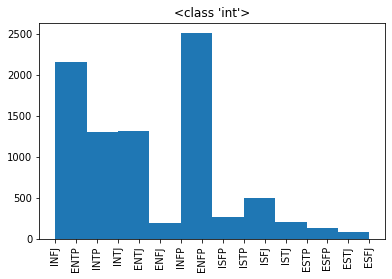

In [69]:
df.type.hist(type)

### Class Distribution

In [5]:
# Number of E N F or P's
ENFP = df.iloc[:,2:6].sum()
ISTJ = df.shape[0]-df.iloc[:,2:6].sum()
ENFP

E/I    6676
N/S    7478
F/T    4694
P/J    5241
dtype: int64

Looks like we have quite a class imbalance!!

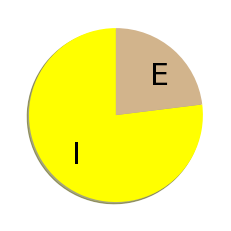

majority class: 0.77


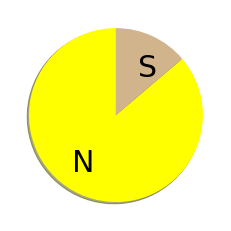

majority class: 0.86


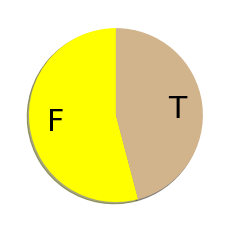

majority class: 0.54


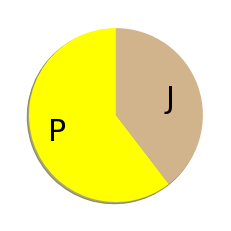

majority class: 0.60


In [10]:
for i, j, label in zip(ENFP, ISTJ,[['I','E'],['N','S'],['F','T'],['P','J']]):
    pi = plt.pie([i, j],
                shadow = True, 
                colors = ('yellow','tan'), 
                startangle = 90, 
                textprops = dict(fontsize = 30),
                labels = label,
                labeldistance = .6)
    plt.savefig(f'plots/{label} pieChart.png',bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    print(f'majority class: {i/8675:.2f}')

# EXPORT to SQL for NLP in other notebook

In [71]:
import d6tstack

# fast CSV to SQL import - see SQL examples notebook
d6tstack.utils.pd_to_psql(df, 
                          'postgresql+psycopg2://briantam: @localhost/myers_briggs', 
                          'cleaned_posts', 
                          if_exists='replace',
                          sep='\t')

True

In [72]:
df.to_csv('cleaned_posts.csv')

# Appendix

## NLP

In [18]:
df

,I-E,J-P,N-S,T-F,type,post,tweet_length,clean_post
3,0,0,1,1,INFJ,What has been the most life-changing experienc...,61,what has been the most life changing experienc...
5,0,0,1,1,INFJ,May the PerC Experience immerse you.,36,may the perc experience immerse you
7,0,0,1,1,INFJ,Hello ENFJ7. Sorry to hear of your distress. I...,200,hello sorry to hear of your distress it s ...
9,0,0,1,1,INFJ,Welcome and stuff.,18,welcome and stuff
11,0,0,1,1,INFJ,"Prozac, wellbrutin, at least thirty minutes of...",201,prozac wellbrutin at least thirty minutes of...
...,...,...,...,...,...,...,...,...
422840,0,1,1,1,INFP,I was going to close my facebook a few months ...,193,i was going to close my facebook a few months ...
422841,0,1,1,1,INFP,30 Seconds to Mars - All of my collections. It...,85,seconds to mars all of my collections it ...
422842,0,1,1,1,INFP,"I have seen it, and i agree. I did actually th...",199,i have seen it and i agree i did actually th...
422843,0,1,1,1,INFP,Ok so i have just watched Underworld 4 (Awaken...,200,ok so i have just watched underworld awaken...


In [160]:
# Split the data into X and y data sets
X = df.clean_post
y = df['I-E']

In [161]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [162]:
X_test

402648                           sleepyfox im crying ahahah
115323    id say xnfj  clear n id go with f over t but t...
308568    hi and welcome glad to see a new addition i ho...
135536    never too late im  and in  year of mba my clas...
23932     not to steal your wordsbut that is exactly wha...
                                ...                        
11470                        hi im here if you need to talk
10705                            so what have you found out
244829    for me as far as looks goes a lot of it is in ...
196953    you win i was only bruised did you bite yourse...
69894     that i either watched disneys notredame de par...
Name: clean_post, Length: 119285, dtype: object

In [21]:
# The first document-term matrix has default Count Vectorizer values - counts of unigrams
cv1 = CountVectorizer(min_df=5, max_features=2000, stop_words='english')

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

cv = pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names()).head()

In [73]:
# The second document-term matrix has both unigrams and bigrams, and indicators instead of counts
cv2 = CountVectorizer(min_df=5, max_features=1000, ngram_range=(1,2), binary=True, stop_words='english')

X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2  = cv2.transform(X_test)

pd.DataFrame(X_train_cv2.toarray(), columns=cv2.get_feature_names()).head()

,ability,able,absolutely,accept,according,accurate,act,action,actions,actual,...,yeah,year,years,years ago,yep,yes,yesterday,young,younger,youtube
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Try classifying using Logistic Regression

In [74]:
# Create a logistic regression model to use
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight = 'balanced')

In [75]:
# Train the first model
lr.fit(X_train_cv1, y_train)
y_pred_cv1 = lr.predict(X_test_cv1)

In [76]:
# Train the second model
lr.fit(X_train_cv2, y_train)
y_pred_cv2 = lr.predict(X_test_cv2)

/Users/briantam/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [77]:
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

In [78]:
df['I-E'].value_counts()

0    304524
1     93090
Name: I-E, dtype: int64

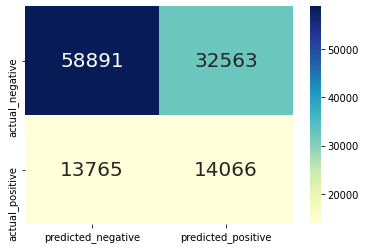

In [79]:
# The heat map for the first logistic regression model
cm1 = conf_matrix(y_test, y_pred_cv1)

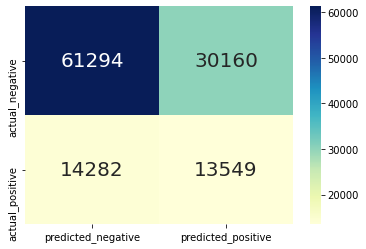

In [80]:
# The heat map for the second logistic regression model
cm2 = conf_matrix(y_test, y_pred_cv2)

In [81]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm1, cm2)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg1', 'LogReg2']
results

,LogReg1,LogReg2
Accuracy,0.612,0.627
Precision,0.302,0.310
Recall,0.505,0.487
F1 Score,0.378,0.379


### Try classifying using Naive Bayes

In [82]:
# Fit the first Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train_cv1, y_train)

y_pred_cv1_nb = mnb.predict(X_test_cv1)

In [83]:
# Fit the second Naive Bayes model
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train_cv2, y_train)

y_pred_cv2_nb = bnb.predict(X_test_cv2)

In [84]:
print(y_test.shape)
y_pred_cv1_nb.shape

(119285,)


(119285,)

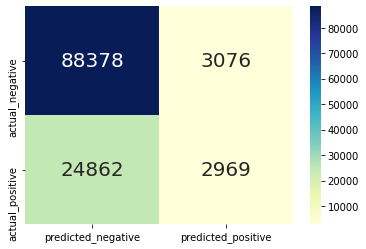

In [85]:
# Here's the heat map for the first Naive Bayes model
cm3 = conf_matrix(y_test, y_pred_cv1_nb)

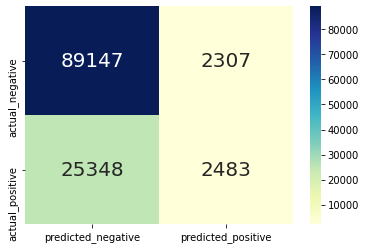

In [86]:
# Here's the heat map for the second Naive Bayes model
cm4 = conf_matrix(y_test, y_pred_cv2_nb)

In [87]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(cm3, cm4)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_nb.columns = ['NB1', 'NB2']
results_nb

results = pd.concat([results, results_nb], axis=1)
results

,LogReg1,LogReg2,NB1,NB2
Accuracy,0.612,0.627,0.766,0.768
Precision,0.302,0.310,0.491,0.518
Recall,0.505,0.487,0.107,0.089
F1 Score,0.378,0.379,0.176,0.152


### Try using TF-IDF instead of Count Vectorizer

In [88]:
# Create TF-IDF versions of the Count Vectorizers created earlier in the exercise
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf1 = TfidfVectorizer(stop_words='english')
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

tfidf2 = TfidfVectorizer(ngram_range=(1,2), binary=True, stop_words='english')
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2  = tfidf2.transform(X_test)

/Users/briantam/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


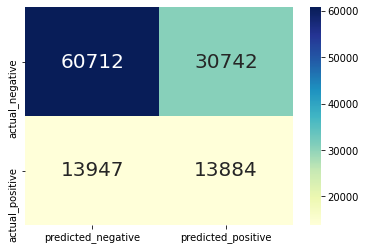

In [89]:
# Fit the first logistic regression on the TF-IDF data
lr.fit(X_train_tfidf1, y_train)
y_pred_tfidf1_lr = lr.predict(X_test_tfidf1)
cm5 = conf_matrix(y_test, y_pred_tfidf1_lr)

/Users/briantam/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


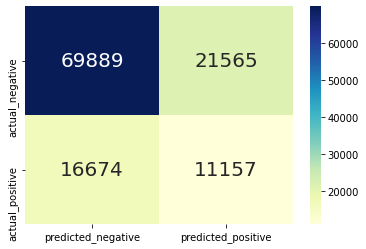

In [90]:
# Fit the second logistic regression on the TF-IDF data
lr.fit(X_train_tfidf2, y_train)
y_pred_tfidf2_lr = lr.predict(X_test_tfidf2)
cm6 = conf_matrix(y_test, y_pred_tfidf2_lr)

## Topic Modeling

### Latent Semantic Analysis (LSA)

In [97]:
# Acronynms: Latent Semantic Analysis (LSA) is just another name for 
#  Signular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
lsa = TruncatedSVD(5)
doc_topic = lsa.fit_transform(pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names()))
lsa.explained_variance_ratio_

array([0.01950523, 0.01762124, 0.01437884, 0.01368814, 0.0129187 ])

Create function to create a short summary list of the topics 

In [98]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    """
    Takes in model and feature names and outputs 
    a list of string of the top words from each topic.
    """
    topics = []
    for ix, topic in enumerate(model.components_):
        topics.append(str(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])))
    return topics

In [103]:
topics = display_topics(lsa, cv1.get_feature_names(), 5)

In [104]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index =  topics,
             columns = cv1.get_feature_names())
topic_word

,ability,able,absolute,absolutely,abstract,accept,accepted,accepting,according,account,...,year,years,yep,yes,yesterday,young,younger,youtube,yup,zone
"like, don, just, people, think",0.004,0.014,0.001,0.008,0.002,0.004,0.001,0.001,0.002,0.002,...,0.016,0.029,0.003,0.040,0.003,0.006,0.006,0.002,0.002,0.002
"like, feel, sounds, sound, looks",-0.002,-0.004,-0.001,-0.002,-0.000,-0.003,-0.000,-0.000,-0.001,-0.001,...,-0.002,-0.008,-0.000,-0.011,-0.001,-0.001,-0.001,-0.000,-0.000,-0.000
"just, ve, time, really, ll",-0.001,0.000,0.000,0.002,0.000,0.001,0.001,-0.000,-0.000,0.000,...,0.009,0.012,0.001,0.004,0.003,0.000,-0.001,0.001,0.000,0.000
"people, just, ve, time, lot",0.002,0.004,0.000,0.002,0.000,0.001,0.001,0.001,-0.000,-0.000,...,0.002,0.005,0.001,0.009,0.000,0.001,0.002,0.000,-0.000,0.000
"think, ve, time, infp, type",0.002,0.005,0.001,0.002,0.001,-0.000,0.000,0.000,0.001,-0.000,...,0.005,0.015,0.001,0.012,0.001,0.002,0.002,0.000,0.000,0.000


The Vt matrix shows us the documents we started with, and how each document is made up of the 2 resulting topics. In this case:
- The first four documents seem to be about thinking
- The last three documents seem to be about feeling

In [105]:
Vt = pd.DataFrame(doc_topic.round(5),
             index = X_train.values,
             columns = topics)
Vt

,"like, don, just, people, think","like, feel, sounds, sound, looks","just, ve, time, really, ll","people, just, ve, time, lot","think, ve, time, infp, type"
when your anger at someone can dissipate in an instant when you see another side and just start to feel sorry for them,0.49760,-0.13833,0.84137,0.15514,-0.02410
so glad that baseball season has started up again today is opening day at coors field in denver and i m off work to watch it go rockies,0.10439,-0.02227,0.04669,0.01573,0.01699
you are correct the horoscope is absolutely bs however astrology is not but many will consider the two one in the same,0.02010,-0.00897,-0.00092,0.00264,0.00247
answering a post thread,0.05475,-0.01569,0.02681,0.00185,0.01828
oh no you didn t just thought i d show the post myself no big deal laughing,0.47804,-0.22915,0.89782,0.15089,0.02114
...,...,...,...,...,...
i ve always had faith things would turn out as they should even if i didn t subscribe to a belief system or religion now with maturity and perspective i understand the real power of belief and,0.35193,-0.11873,0.06968,0.08399,0.14906
yes she and myself and my husband actually are all highly sensitive people i have read about this and was not surprised that the three of us fall into that category enfj s are actually very,0.51115,-0.31151,-0.37395,0.79250,-0.10860
you should lay those sick rhythms down at slam poetry night and see how many people you attract then,0.31109,-0.24788,-0.39210,0.77819,-0.18957
halloween,0.00000,-0.00000,-0.00000,-0.00000,-0.00000


### Explode Posts
import utility that allows me to **explode** my posts into a seperate row each

In [53]:
df_exploded['tweet_length'] = df['post'].apply(lambda x: len(x))
df_exploded.head()

,I-E,J-P,N-S,T-F,type,post,tweet_length
3,0,0,1,1,INFJ,What has been the most life-changing experienc...,61
5,0,0,1,1,INFJ,May the PerC Experience immerse you.,36
7,0,0,1,1,INFJ,Hello ENFJ7. Sorry to hear of your distress. I...,200
9,0,0,1,1,INFJ,Welcome and stuff.,18
11,0,0,1,1,INFJ,"Prozac, wellbrutin, at least thirty minutes of...",201


In [13]:
from utilities.explode_posts import explode
df_exploded = explode(df, ['post'], fill_value='')

IndentationError: expected an indented block (explode_posts.py, line 4)

In [53]:
df_exploded['tweet_length'] = df['post'].apply(lambda x: len(x))
df_exploded.head()

,I-E,J-P,N-S,T-F,type,post,tweet_length
3,0,0,1,1,INFJ,What has been the most life-changing experienc...,61
5,0,0,1,1,INFJ,May the PerC Experience immerse you.,36
7,0,0,1,1,INFJ,Hello ENFJ7. Sorry to hear of your distress. I...,200
9,0,0,1,1,INFJ,Welcome and stuff.,18
11,0,0,1,1,INFJ,"Prozac, wellbrutin, at least thirty minutes of...",201


In [51]:
links_df = df[['http' in post for post in df['post']]]
links_df.head()

,I-E,J-P,N-S,T-F,type,post
0,0,0,1,1,INFJ,http://www.youtube.com/watch?v=qsXHcwe3krw
1,0,0,1,1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2,0,0,1,1,INFJ,enfp and intj moments https://www.youtube.com...
4,0,0,1,1,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...
6,0,0,1,1,INFJ,The last thing my INFJ friend posted on his fa...


In [52]:
df.drop(df[['http' in post for post in df['post']]].index, inplace = True)

Text preprocessing steps - remove numbers, captial letters and punctuation

In [54]:
alphanumeric = lambda x: re.sub('\w*\d\w*', '', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower())

df['clean_post'] = df.post.map(alphanumeric).map(punc_lower)
df

,I-E,J-P,N-S,T-F,type,post,tweet_length,clean_post
3,0,0,1,1,INFJ,What has been the most life-changing experienc...,61,what has been the most lifechanging experience...
5,0,0,1,1,INFJ,May the PerC Experience immerse you.,36,may the perc experience immerse you
7,0,0,1,1,INFJ,Hello ENFJ7. Sorry to hear of your distress. I...,200,hello sorry to hear of your distress its only...
9,0,0,1,1,INFJ,Welcome and stuff.,18,welcome and stuff
11,0,0,1,1,INFJ,"Prozac, wellbrutin, at least thirty minutes of...",201,prozac wellbrutin at least thirty minutes of m...
...,...,...,...,...,...,...,...,...
422840,0,1,1,1,INFP,I was going to close my facebook a few months ...,193,i was going to close my facebook a few months ...
422841,0,1,1,1,INFP,30 Seconds to Mars - All of my collections. It...,85,seconds to mars all of my collections it see...
422842,0,1,1,1,INFP,"I have seen it, and i agree. I did actually th...",199,i have seen it and i agree i did actually thin...
422843,0,1,1,1,INFP,Ok so i have just watched Underworld 4 (Awaken...,200,ok so i have just watched underworld awakenin...


Compare example post before and after preprocessing

In [36]:
print(df.post[7], '\n')
print(df.clean_post[7])

Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as... 

hello  sorry to hear of your distress its only natural for a relationship to not be perfection all the time in every moment of existence try to figure the hard times as times of growth as


In [32]:
df.tweet_length.hist(bins=50)

AttributeError: 'DataFrame' object has no attribute 'tweet_length'

#### d6tstack

In [11]:
d6tstack.utils.pd_to_psql?

Signature:
d6tstack.utils.pd_to_psql(
    df,
    uri,
    table_name,
    schema_name=None,
    if_exists='fail',
    sep=',',
)
Docstring:
Load pandas dataframe into a sql table using native postgres COPY FROM.

Args:
    df (dataframe): pandas dataframe
    uri (str): postgres psycopg2 sqlalchemy database uri
    table_name (str): table to store data in
    schema_name (str): name of schema in db to write to
    if_exists (str): {‘fail’, ‘replace’, ‘append’}, default ‘fail’. See `pandas.to_sql()` for details
    sep (str): separator for temp file, eg ',' or ' '

Returns:
    bool: True if loader finished
File:      ~/opt/anaconda3/envs/metis/lib/python3.8/site-packages/d6tstack/utils.py
Type:      function


In [149]:
import d6tstack

# fast CSV to SQL import - see SQL examples notebook
d6tstack.utils.pd_to_psql(df, 'postgresql+psycopg2://briantam: @localhost/myers_briggs', 'twitter', if_exists='replace')

True

In [ ]:
# Create our list of punctuation marks
punctuations = df.post[3].punctuation
# Create our list of stopwords
spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
# Load English tokenizer, tagger, parser, NER and word vectors
parser = EN()
# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    # return preprocessed list of tokens
    return mytokens